In [1]:
import numpy as np
import json
import gensim
from tqdm import tqdm
import tensorflow as tf
import pickle
from sklearn.model_selection import train_test_split
from collections import defaultdict
from sklearn.manifold import TSNE
from scipy import sparse
import matplotlib.pyplot as plt
%matplotlib inline

# **Section 1:- Training**

# Question 2:-

In [ ]:
data = []
with open('Electronics_5.json') as file:
    for line in tqdm(file):
        data.append(''.join(ch if ch.isalnum() else ' ' for ch in json.loads(line)['reviewText'].lower()))
    file.close()

In [ ]:
word_freq = defaultdict(int)
for sentence in tqdm(data):
    sentence = sentence.split()
    for word in sentence:
        word_freq[word]+=1

In [ ]:
data_2 = []
for sentence in tqdm(data):
    sentence = sentence.split()
    data_2.append(' '.join([word for word in sentence if word_freq[word]>4]))

In [ ]:
train, test = train_test_split(data_2, test_size=0.1, random_state=42)

In [ ]:
# tokenizer = tf.keras.preprocessing.text.Tokenizer()
# tokenizer.fit_on_texts(data_2)

with open('models/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

train_tokenized_text = tokenizer.texts_to_sequences(train)
test_tokenized_text = tokenizer.texts_to_sequences(test)

In [ ]:
num_unique_words = len(tokenizer.word_index.keys())
num_unique_words

In [ ]:
len(train_tokenized_text), len(test_tokenized_text)

In [ ]:
num_context_words = 8
embed_dim = 256
# num_unique_words = 100715

In [ ]:
word2vec_cbow = tf.keras.models.Sequential()
word2vec_cbow.add(tf.keras.layers.Embedding(input_dim=num_unique_words, output_dim=embed_dim, input_length=8))
word2vec_cbow.add(tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=1), output_shape=(embed_dim,)))
word2vec_cbow.add(tf.keras.layers.Dense(num_unique_words, activation='softmax'))

In [ ]:
word2vec_cbow.compile(loss='categorical_crossentropy', optimizer='sgd')

In [ ]:
# word2vec_cbow.load_weights('../input/models/weights.best.hdf5')

In [ ]:
word2vec_cbow.summary()

In [ ]:
def get_training_data(tokenized_data):
    for _, sentence in enumerate(tokenized_data):
        for c, i in enumerate(range(4, len(sentence)-4)):
            contexts = [sentence[i-4:i]+sentence[i+1:i+5]]
            target = sentence[i]

            contexts = tf.keras.preprocessing.sequence.pad_sequences(contexts, maxlen=8)
            target = tf.keras.utils.to_categorical(target, num_unique_words).reshape(1,num_unique_words)
        
            yield (contexts, target)

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='models/weights.best.hdf5', 
                                                  verbose = 1, 
                                                  save_best_only = True)

In [ ]:
word2vec_cbow.fit_generator(get_training_data(train_tokenized_text), 
                            epochs=25,
                            steps_per_epoch=500000,
                            validation_data = get_training_data(test_tokenized_text),
                            validation_steps=50000,
                            callbacks = [checkpointer],
                            verbose=1)

In [ ]:
f = open('models/cbow_vecs.txt' ,'w')
f.write('{} {}\n'.format(len(tokenizer.word_index), 256))

In [ ]:
cbow_weights = word2vec_cbow.get_weights()[0]
for word, i in tqdm(tokenizer.word_index.items()):
    str_vec = ' '.join(map(str, list(cbow_weights[i-1, :])))
    f.write('{} {}\n'.format(word, str_vec))
f.close()

# Section 2:- Inference

In [84]:
# Function to calculate the top10 words and plot using t-SNE
def plot_top10_words(word, cbow_own):

    def tsne_plot(results):
        words = []
        embeds = []

        for res in results:
            embeds.append(res[1])
            words.append(res[0])
        
        tsne_model = TSNE(init='pca')
        res_embeds = tsne_model.fit_transform(embeds)

        x_axis_val = []
        y_axis_val = []
        for val in res_embeds:
            x_axis_val.append(val[0])
            y_axis_val.append(val[1])
            
        plt.figure(figsize=(10, 10)) 
        for i in range(len(x_axis_val)):
            plt.scatter(x_axis_val[i],y_axis_val[i])
            plt.annotate(words[i],
                        xy=(x_axis_val[i],y_axis_val[i]),
                        xytext=(5, 2),
                        textcoords='offset points',
                        ha='right',
                        va='bottom')
        plt.show()
    
    similar_words = cbow_own.most_similar(positive=[word], topn = 10)
    res = {}
    for i, embed in tqdm(enumerate(similar_words)):
        res[embed[0]] = [embed[1], cbow_own[embed[0]]]


    results = []
    for t in sorted(res.items(), key=lambda item: item[1][0], reverse=True)[0:10]:
        results.append([t[0], t[1][1]])

    print('Word:-', word)
    print('Words:-', end='\t')
    for res in results:
        print(res[0], end=', ')
    print()

    tsne_plot(results)

In [3]:
#Load self trained cbow model
cbow_own = gensim.models.KeyedVectors.load_word2vec_format('models/cbow_vecs.txt', binary=False)

# Question 3

10it [00:00, 56148.65it/s]


Word:- payment
Words:-	pilot, grey, contacts, receiving, pounds, savings, 690, contract, d300, compression, 


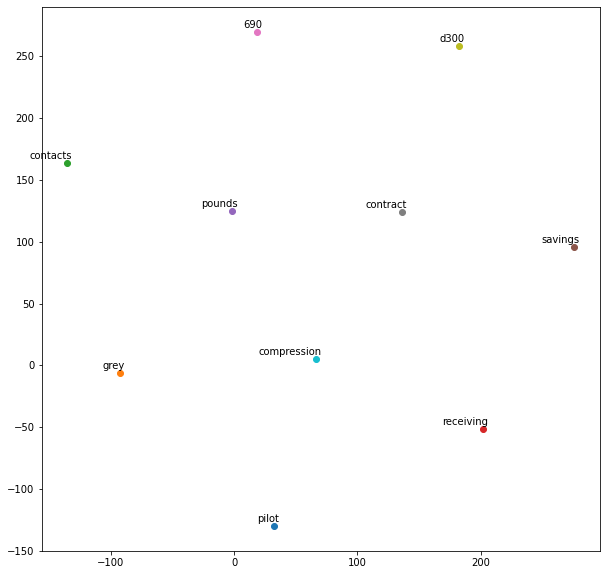

In [85]:
plot_top10_words('payment', cbow_own)

10it [00:00, 51781.53it/s]


Word:- laptop
Words:-	smart, games, different, please, router, comments, obviously, made, order, xbox, 


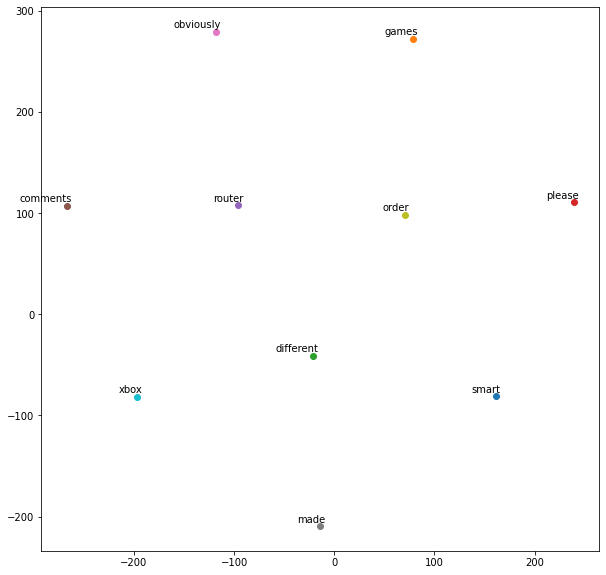

In [86]:
plot_top10_words('laptop', cbow_own)

10it [00:00, 54755.93it/s]


Word:- music
Words:-	kept, earphone, safe, biggest, windows, making, cameras, tabs, keeps, laptops, 


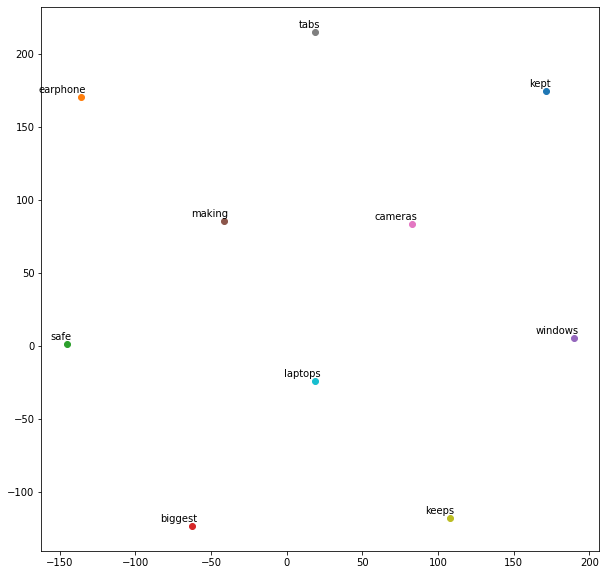

In [87]:
plot_top10_words('music', cbow_own)

10it [00:00, 55924.05it/s]


Word:- processor
Words:-	iphone, cf, wants, nowhere, disk, clips, connection, price, faster, useful, 


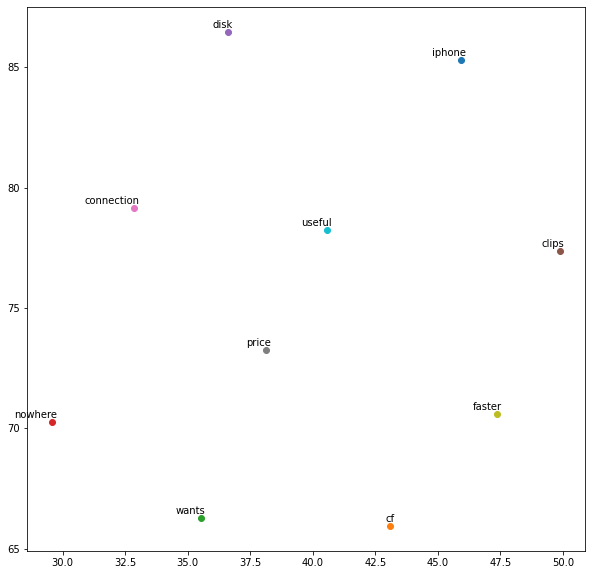

In [100]:
plot_top10_words('processor', cbow_own)

10it [00:00, 47934.90it/s]


Word:- screen
Words:-	cover, connections, 1080p, seen, non, lens, wide, used, don, lenses, 


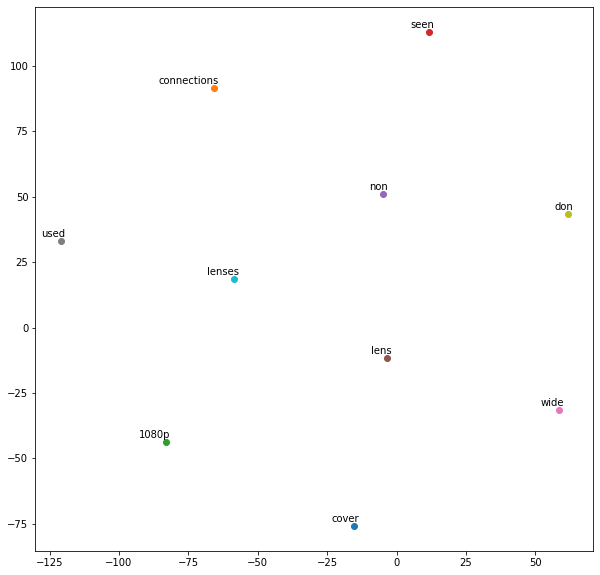

In [122]:
plot_top10_words('screen', cbow_own)

# Question 4

10it [00:00, 52958.38it/s]


Word:- camera
Words:-	mp3, ipod, mentioned, hours, would, make, saved, screen, amazon, enough, 


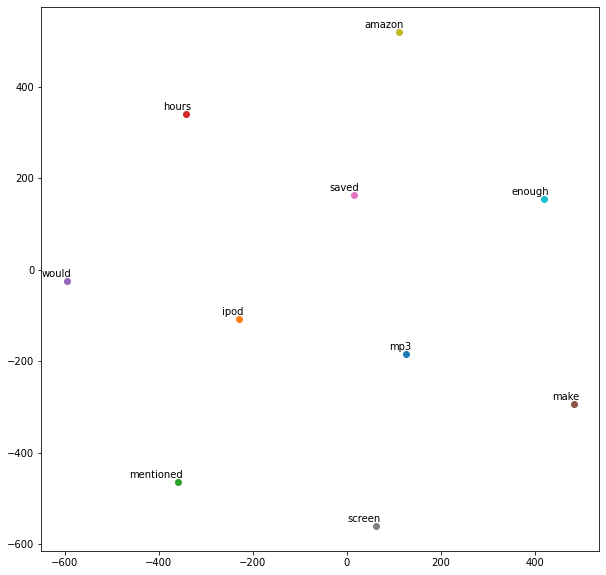

In [123]:
plot_top10_words('camera', cbow_own)

In [124]:
# if pretrained word2vec not present uncomment below code and run this cell

# !wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

# !gzip -d GoogleNews-vectors-negative300.bin.gz

--2021-09-11 06:40:07--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.109.165
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.109.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  39.2MB/s    in 40s     

2021-09-11 06:40:48 (39.0 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [125]:
# load pretrained model
# Consider restarting before running this cell as this might crash server
pretrained_word2vec = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

10it [00:00, 24600.02it/s]


Word:- camera
Words:-	cameras, Wagging_finger, camera_lens, camcorder, Camera, Canon_digital_SLR, Cameras, Nikon_D####_digital_SLR, tripod, EyeToy_USB, 


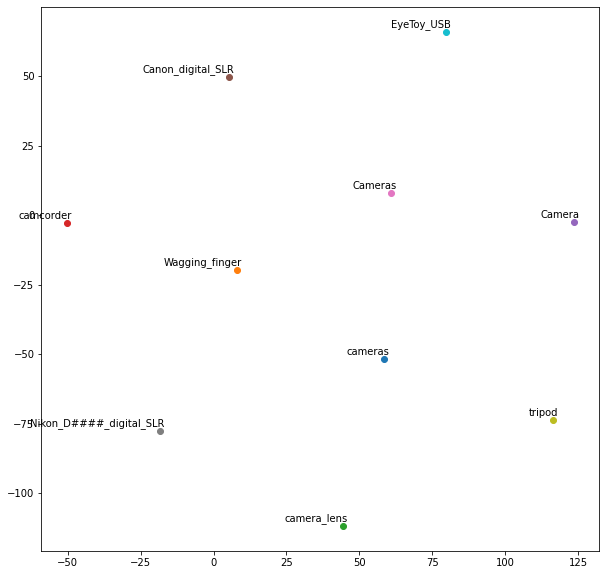

In [126]:
plot_top10_words('camera', pretrained_word2vec)